In [2]:
#!pip install xgboost
#!pip install imblearn

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

## 1. Load & Preview Data

In [4]:
# Load the CSV
df = pd.read_csv("../data/Telco_Customer_Churn_feature_engineered_v1.csv")

# Quick preview
df.head()

,customerID,IsSeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,HasPartnerOrDependents,ExpectedTotalCharges,BillingDiffPct,Churn_num,...,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,TenureGroup_Early,TenureGroup_Loyal,PackageChangeBehavior_Downgrade,PackageChangeBehavior_Upgrade
0,7590-VHVEG,0,1,29.85,29.85,No,1,29.85,0.000000,0,...,False,False,True,False,True,False,False,False,False,False
1,5575-GNVDE,0,34,56.95,1889.50,No,0,1936.30,-0.024170,0,...,True,False,False,False,False,True,False,True,True,False
2,3668-QPYBK,0,2,53.85,108.15,Yes,0,107.70,0.004178,1,...,False,False,True,False,False,True,False,False,False,False
3,7795-CFOCW,0,45,42.30,1840.75,No,0,1903.50,-0.032965,0,...,True,False,False,False,False,False,False,True,True,False
4,9237-HQITU,0,2,70.70,151.65,Yes,0,141.40,0.072484,1,...,False,False,True,False,True,False,False,False,False,True


In [5]:
X = df.drop(columns=['customerID', 'Churn','Churn_num'])
y = df['Churn_num']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [6]:
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

In [7]:
def precision_recall_curve_draw(precisions, recalls, thresholds, threshold):
    plt.figure(figsize=(8, 5))
    plt.plot(thresholds, precisions[:-1], label='Precision', color='blue')
    plt.plot(thresholds, recalls[:-1], label='Recall', color='green')
    plt.axvline(x=threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title("Precision and Recall vs Threshold")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## 2 Standardise the data ✅

In [8]:
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges','ExpectedTotalCharges','BillingDiffPct']

# Initialize the scaler
scaler = StandardScaler()

# Fit only on training data to avoid data leakage
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])

# Apply the same transformation to test data
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])


scaler_sm = StandardScaler()

# Fit only on training data to avoid data leakage
X_train_sm[numerical_cols] = scaler_sm.fit_transform(X_train_sm[numerical_cols])

X_test_sm = X_test.copy()

# Apply the same transformation to test data
X_test_sm[numerical_cols] = scaler_sm.transform(X_test_sm[numerical_cols])

## 3a. Model Training With Standardisation (Logistic Regression) ❌

### 🔍 Logistic Regression with grid search

In [9]:
#Defining the Logistic Regression model
log_reg = LogisticRegression(max_iter=10000, random_state = 42)

# Grid of hyperparameters 
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1','l2'], 
    'solver': ['saga'],
    'class_weight': ['balanced']
}

# Grid Search with recall as the scoring metric because accuracy is not a good measure in imbalanced datasets and catching churn is the business case
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='recall', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model evaluation
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("🔧 Best Parameters:", grid_search.best_params_)
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=["No Churn", "Churn"]))


🔧 Best Parameters: {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'}

📊 Classification Report:
              precision    recall  f1-score   support

    No Churn       0.91      0.72      0.81      1035
       Churn       0.51      0.81      0.63       374

    accuracy                           0.75      1409
   macro avg       0.71      0.77      0.72      1409
weighted avg       0.81      0.75      0.76      1409



### 🎯 Logistic Regression changing threshold

📉 Threshold set to: 0.4
              precision    recall  f1-score   support

    No Churn       0.94      0.64      0.76      4139
       Churn       0.47      0.88      0.61      1495

    accuracy                           0.71      5634
   macro avg       0.70      0.76      0.69      5634
weighted avg       0.81      0.71      0.72      5634



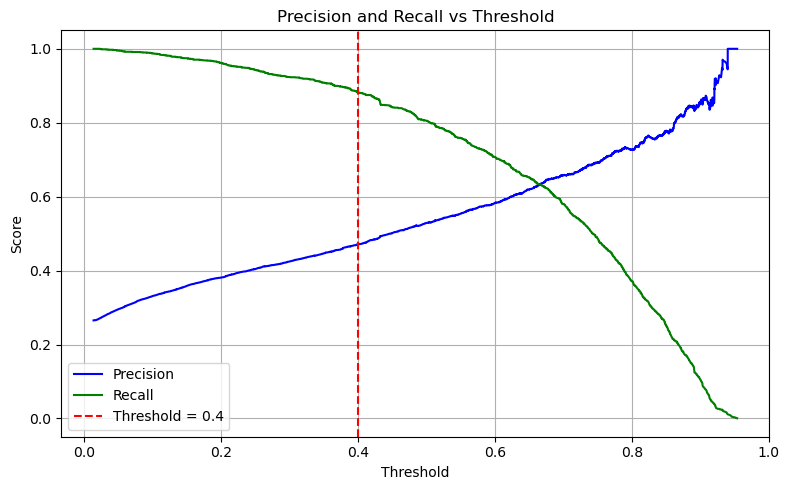

In [10]:
# Changing threshold based on training
# 1. Get predicted probabilities for the positive class (Churn = 1)
y_probs = best_model.predict_proba(X_train)[:, 1]

# 2. Set custom threshold
threshold = 0.4  #After reading the graph
y_pred_threshold = (y_probs >= threshold).astype(int)

# 3. Evaluate performance
print(f"📉 Threshold set to: {threshold}")
print(classification_report(y_train, y_pred_threshold, target_names=["No Churn", "Churn"]))

# 4. (Optional) Plot Precision-Recall vs. Threshold curve
precisions, recalls, thresholds = precision_recall_curve(y_train, y_probs)

precision_recall_curve_draw(precisions, recalls, thresholds, threshold)

In [11]:
# Evaluate the threshold change on the test data
# 1. Get predicted probabilities for the positive class (Churn = 1)
y_probs = best_model.predict_proba(X_test)[:, 1]

# 2. Set custom threshold
threshold = 0.4  #After reading the graph
y_pred_threshold = (y_probs >= threshold).astype(int)

# 3. Evaluate performance
print(f"📉 Threshold set to: {threshold}")
print(classification_report(y_test, y_pred_threshold, target_names=["No Churn", "Churn"]))


📉 Threshold set to: 0.4
              precision    recall  f1-score   support

    No Churn       0.93      0.64      0.76      1035
       Churn       0.47      0.87      0.61       374

    accuracy                           0.70      1409
   macro avg       0.70      0.75      0.68      1409
weighted avg       0.81      0.70      0.72      1409



### 🧪 Logistic Regression SMOTE

In [12]:
#Defining the Logistic Regression model
log_reg = LogisticRegression(max_iter=10000, random_state = 42)

# Grid of hyperparameters 
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1','l2'], 
    'solver': ['saga'],
    'class_weight': ['balanced']
}

# Grid Search with recall as the scoring metric because accuracy is not a good measure in imbalanced datasets and catching churn is the business case
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='recall', n_jobs=-1)
grid_search.fit(X_train_sm, y_train_sm)

# Best model evaluation
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_sm)

print("🔧 Best Parameters:", grid_search.best_params_)
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=["No Churn", "Churn"]))

🔧 Best Parameters: {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'saga'}

📊 Classification Report:
              precision    recall  f1-score   support

    No Churn       0.95      0.15      0.26      1035
       Churn       0.29      0.98      0.45       374

    accuracy                           0.37      1409
   macro avg       0.62      0.57      0.36      1409
weighted avg       0.78      0.37      0.31      1409



### 📌 Conclusion on Logistic Regression

The Logistic Regression model demonstrated strong performance in identifying churned customers. After extensive hyperparameter tuning and class balancing techniques, including SMOTE, the model achieved a recall of 80% on the churn class. However, this came at the cost of precision, resulting in an overall accuracy of 46% on the churn predictions.

While SMOTE did not yield further improvements in recall compared to class weighting and threshold adjustment alone, it confirmed the model’s robustness across different balancing strategies.

## List of Emojis 🔍🎯🧪🎛️📌✅❌🌳🌲🧮⚡